Image Compression using Clustering Algorithms


1) Using in built kmean clustering

In [ ]:
from skimage.util import view_as_blocks

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [19]:
def squared_error_distortion(img, compressed_img):
    return np.mean(np.square((img.astype(int) - compressed_img.astype(int))))

def find_entropy(l):
    d = {}
    for i in l:
        if i not in d:
            d[i] = 0
        d[i] += 1
    H = []
    prob = []
    for i in d:
        p = d[i]/len(l)
        prob.append(p)
        H.append(p*np.log2(p))
    return -1* sum(H)

In [ ]:
def compress(img, P, R):
    M, N = img.shape
    patches = view_as_blocks(img, (P, P))
    X = patches.reshape(M//P,N//P,1,P**2).squeeze().reshape((M//P)**2,1,P**2).squeeze()
    bits_fr_encoded = int(np.ceil(R*(P**2)))
    C = 2**bits_fr_encoded
    kmeans = KMeans(n_clusters=C, random_state=42).fit(X)
    labels = kmeans.labels_
    cc = kmeans.cluster_centers_
    temp = np.zeros(X.shape, dtype=np.uint8)
    for i in range(len(labels)):
        temp[i] = cc[labels[i]]
    temp = temp.reshape(M//P,N//P, 1,P**2).reshape(M//P,N//P,P,P)
    
    compress_img = np.zeros(img.shape, dtype=np.uint8)
    for i in range(temp.shape[0]):
        for j in range(temp.shape[1]):
            compress_img[i*P:P*(i+1), P*j:P*(j+1)] = temp[i][j]
    H = find_entropy(labels)
    r = H/(P**2)

    return compress_img, np.round(r, 2)

In [ ]:
path = "./test_image_3.jpg"
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

### Original Image

(-0.5, 2047.5, 2047.5, -0.5)

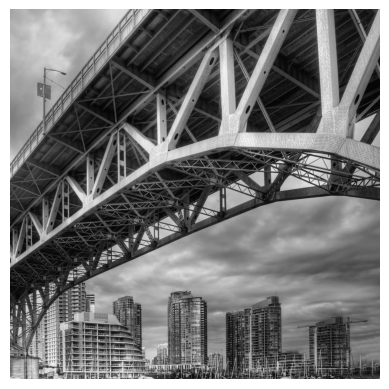

In [ ]:
plt.imshow(img, cmap='gray')
plt.axis(False)

A greyscale image of dimensions 2048 x 2048 was loaded.

Image compression for patch size P = 2 x 2 and rate R = 1 is demonstrated below

In [ ]:
compress_img, _ = compress(img, 2, 1)

(-0.5, 2047.5, 2047.5, -0.5)

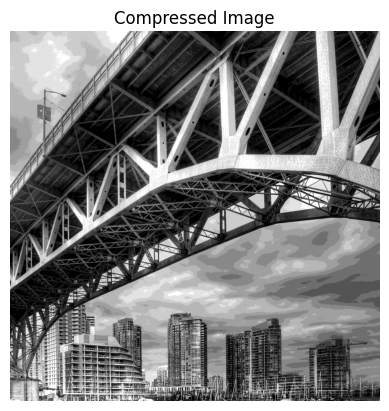

In [ ]:
plt.imshow(compress_img, cmap='gray')
plt.title("Compressed Image")
plt.axis(False)

(-0.5, 63.5, 63.5, -0.5)

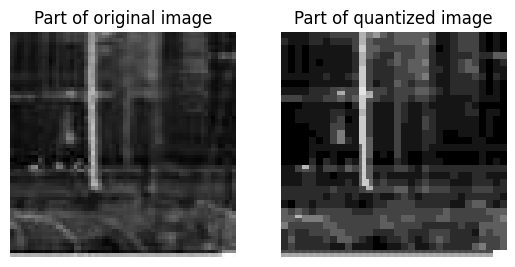

In [ ]:
plt.subplot(121)
cropped_img_original = img[-64:,-64:]
plt.imshow(cropped_img_original, cmap='gray')
plt.title("Part of original image")
plt.axis(False)
plt.subplot(122)
croppped_img = compress_img[-64:,-64:]
plt.imshow(croppped_img, cmap='gray')
plt.title("Part of quantized image")
plt.axis(False)

## Rate vs Distortion

In [ ]:
R = [0.2, 0.4, 0.6, 0.8, 1]
D = []
P = 2
for r in R:
    compress_img, _ = compress(img, P, r)
    D.append(squared_error_distortion(img, compress_img))

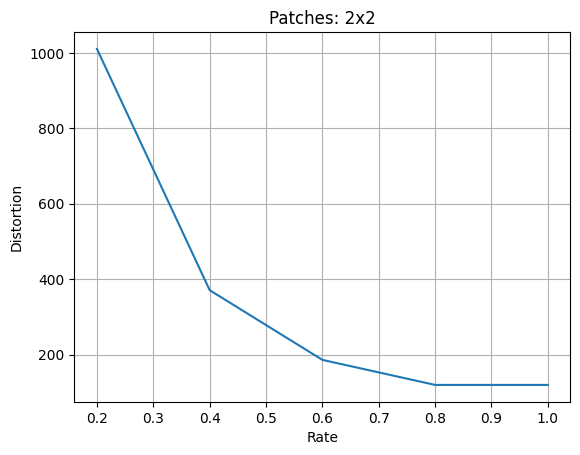

In [ ]:
plt.plot(R, D)
plt.xlabel('Rate')
plt.ylabel('Distortion')
plt.title(f'Patches: {P}x{P}')
plt.grid()

<B> Discussion <br> </B>
As rate i.e., the average number of bits needed to encode each pixel increases, the distortion i.e., the loss in compression, reduces.

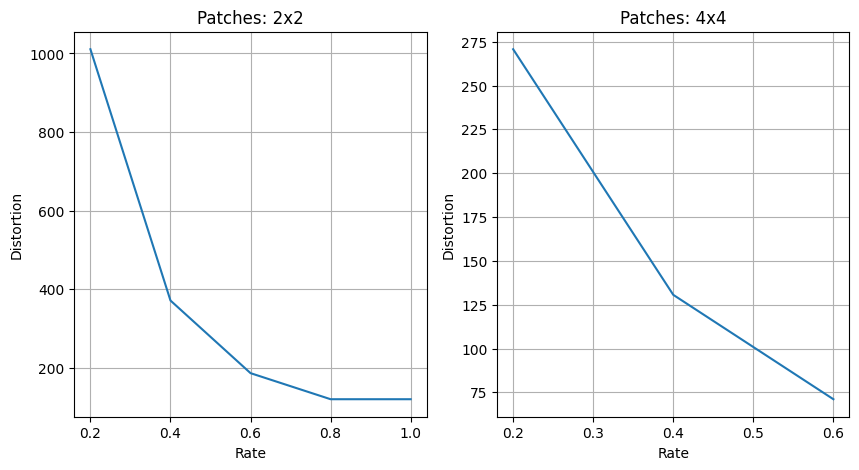

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)

plt.plot(R, D)
plt.xlabel('Rate')
plt.ylabel('Distortion')
plt.title(f'Patches: {P}x{P}')
plt.grid()

plt.subplot(122)

R = [0.2, 0.4, 0.6]
D = []
P = 4
for r in R:
    compress_img, _ = compress(img, P, r)
    D.append(squared_error_distortion(img, compress_img))

plt.plot(R, D)
plt.xlabel('Rate')
plt.ylabel('Distortion')
plt.title(f'Patches: {P}x{P}')
plt.grid()


<B> Discussion <br> </B>
As per the formula, as the number of patches increases, number of cluster centers also increases and this causes less distortion.
<br>
<br>
A smaller patch size captures the intricacies of the image and can fit better with other images as well. As patch size increases, the model overfits to that particular image. Hence, the distortion with respect to itself would be less. This wouldn't work well with other images. Distortion will be high when such a model is applied to other images. 
<br>
<br>
Ideally, one must find the best combination of patches to compress a set of images to obtain a model that delivers optimal/best performance for all the iamges of that set.

### Entropy Coding

For patch size = 2, we obtain 8% reduction in coding rate. 

In [ ]:
_, r_2 = compress(img, 2, 1)
r_2

0.92

For a patch size = 4, we obtain 11.67% reduction in coding rate.

In [ ]:
_, r_4 = compress(img, 4, 0.6)
r_4

0.53

## K-means from scratch

In [6]:
import matplotlib.pyplot as plt
from skimage.util import view_as_blocks
import numpy as np
import pandas as pd
import cv2
import time

path = "./test_image_3.jpg"
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

In [7]:
#function to calculate euclidean distance between points to cluster centers
def euclidean(point, data):
    return np.sqrt(np.sum((point - data)**2, axis=1))

In [12]:
class kmeans:
    def __init__(self, n_clusters, max_iteration=20):
        self.num_clusters = n_clusters
        self.max_iter = max_iteration

    def fit(self, X):
        #taking min and max pixel values
        min, max = np.min(X, axis=0), np.max(X, axis=0)
        #randomly select n centroid points between min and max value distributed uniformly
        self.centroids = [np.random.uniform(min, max) for _ in range(self.num_clusters)]
      
        iteration = 0
        previous_centroids = None
        #condition to check if centroid points repeats then stop or iteration more than max_ter then stop
        while np.not_equal(self.centroids, previous_centroids).any() and iteration < self.max_iter:
           
            sorted_points = [[] for _ in range(self.num_clusters)]
            for x in X:
                dists = euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)                   #taking index of minimum distance or nearest neighbor 
                sorted_points[centroid_idx].append(x)                      
            
            previous_centroids = self.centroids                    #updating centroid value in a list so that we can check if centroids are changing or not
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]

            #to check cluster with no points/pixels
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any(): 
                    self.centroids[i] = previous_centroids[i]
            iteration += 1
            print(iteration)

    def labels(self, X):
        centroid = []
        centroid_indxes = []
        for x in X:
            dists = euclidean(x, self.centroids)              #calculating the distance between each points and final centroid value
            centroid_index = np.argmin(dists) 
            centroid.append(self.centroids[centroid_index])
            centroid_indxes.append(centroid_index)             #labels of each point
        return centroid_indxes, self.centroids


In [13]:
def compress1(img, P, R):
    M, N = img.shape
    patches = view_as_blocks(img, (P, P))
    X = patches.reshape(M//P,N//P,1,P**2).squeeze().reshape((M//P)**2,1,P**2).squeeze()
    bits_fr_encoded = int(R*(P**2))
    C = 2**bits_fr_encoded
    start_time = time.time()
    kmean = kmeans(n_clusters=C)
    kmean.fit(X)
    classification, points = kmean.labels(X)
    end_time = time.time()
    temp = np.zeros(X.shape, dtype=np.uint8)
    for i in range(len(classification)):
        temp[i] = points[classification[i]]
    temp = temp.reshape(M//P,N//P, 1,P**2).reshape(M//P,N//P,P,P)
    
    compress_img = np.zeros(img.shape, dtype=np.uint8)
    for i in range(temp.shape[0]):
        for j in range(temp.shape[1]):
            compress_img[i*P:P*(i+1), P*j:P*(j+1)] = temp[i][j]
    
    return compress_img, start_time, end_time

In [ ]:
compress_img1, start_time, end_time = compress1(img, 4, 0.2)
print(end_time-start_time)

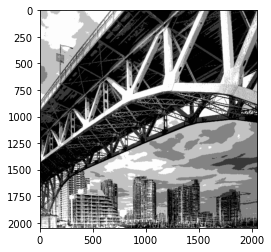

In [15]:
plt.imshow(compress_img1, cmap='gray')

In [ ]:
R = [0.2, 0.4, 0.6, 0.8, 1]
D = []
P = 2
for r in R:
    compress_img, _, _ = compress1(img, P, r)
    D.append(squared_error_distortion(img, compress_img))

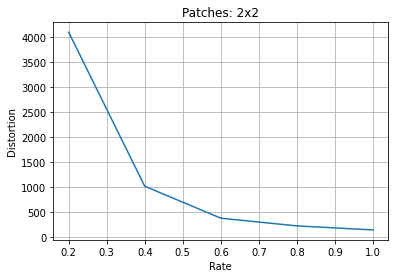

In [21]:
plt.plot(R, D)
plt.xlabel('Rate')
plt.ylabel('Distortion')
plt.title(f'Patches: {P}x{P}')
plt.grid()

## Another clustering algorithm
Fuzzy c means clustering

K mean is hard clustering but Fuzzy c means is a soft clustering. 

In the case of the fuzzy c-means algorithm, the data point can belong to more than one cluster with a likelihood whereas in k means it belongs to only one cluster. Fuzzy c-means clustering gives comparatively better results for overlapped data sets.

In [25]:
from fcmeans import FCM

def compress2(img, P, R):
    M, N = img.shape
    patches = view_as_blocks(img, (P, P))
    X = patches.reshape(M//P,N//P,1,P**2).squeeze().reshape((M//P)**2,1,P**2).squeeze()
    bits_fr_encoded = int(R*(P**2))
    C = 2**bits_fr_encoded
    start_time = time.time()    
    fcm = FCM(n_clusters=C)
    fcm.fit(X)
    fcm_centers = fcm.centers
    fcm_labels = fcm.predict(X)
    end_time = time.time()
    temp = np.zeros(X.shape, dtype=np.uint8)
    for i in range(len(fcm_labels)):
        temp[i] = fcm_centers[fcm_labels[i]]
    temp = temp.reshape(M//P,N//P, 1,P**2).reshape(M//P,N//P,P,P)
    
    compress_img = np.zeros(img.shape, dtype=np.uint8)
    for i in range(temp.shape[0]):
        for j in range(temp.shape[1]):
            compress_img[i*P:P*(i+1), P*j:P*(j+1)] = temp[i][j]
    
    return compress_img, start_time, end_time

In [ ]:
compress_img, start_time, end_time = compress2(img, 4, 0.2)
print(end_time-start_time)

47.111382484436035


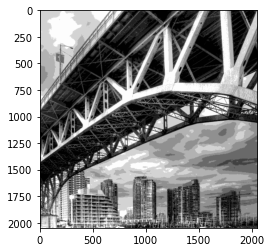

In [ ]:
plt.imshow(compress_img, cmap='gray')

In [27]:
R = [0.2, 0.4, 0.6, 0.8, 1]
D = []
P = 2
for r in R:
    compress_img, _, _ = compress2(img, P, r)
    D.append(squared_error_distortion(img, compress_img))

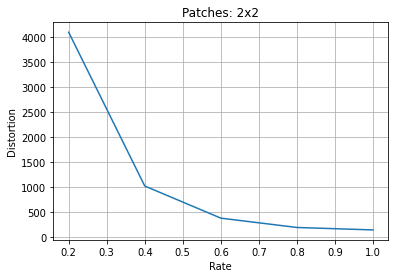

In [28]:
plt.plot(R, D)
plt.xlabel('Rate')
plt.ylabel('Distortion')
plt.title(f'Patches: {P}x{P}')
plt.grid()

There is a huge reduction in distortion as value of Rate change from 0.2 to 0.4 and so on. We can see that for the R value equal to 1 the distortion is close to 100. Its slightly better than Kmeans clustering technique

Run Time Comparison: (in seconds)

for P = 2 and R = 1:

1.   in built k_means time: 32.736351013183594
2.   k_means from scratch: 445.2068884372711
3.   fcmeans: 33.11645817756653

for P = 4 and R = 0.2:

1.   in built k_means time: 13.96139907836914
2.   k_means from scratch: 126.62154030799866
3.   fcmeans: 47.111382484436035



Time taken to run Fuzzy c means is more than kmeans 




